In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Oct 30 17:58:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import scipy.io
import random
import math
import scipy.io as sio
import h5py
import matplotlib as mpl
from cycler import cycler

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.empty_cache()

In [ ]:
from utilities3 import *

# 3d fourier layers

Adopt the structure of Fourier Neural Operator from the paper [Fourier Neural Operator for Parametric Partial Differential Equations
](https://arxiv.org/abs/2010.08895)

In [ ]:

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes

        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width, inputsize, inputsize_vector):
        super(FNO3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.inputsize=inputsize
        self.inputsize_vector = inputsize_vector 
        # self.fc0 = nn.Linear(inputsize, self.width)
        self.fc0_ = nn.Parameter(torch.rand(inputsize_vector[1], inputsize_vector[2], inputsize_vector[3],\
                                            inputsize_vector[4],self.width, dtype=torch.float))


        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)

        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 64)
        self.fc2 = nn.Linear(64, 1)

    def compl_mul3d(self, input, weights):
        return torch.einsum("bixyz,ixyzg->bixyg", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y, size_z = x.shape[1], x.shape[2], x.shape[3]

        x =  self.compl_mul3d(x, self.fc0_) # Here is the adjustment for this work, can achive much better performance than the original structure 

        x = x.permute(0, 4, 1, 2, 3)
        x1 = self.conv0(x)
        x2 = self.w0(x.reshape(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = F.relu(x)
        x1 = self.conv1(x)
        x2 = self.w1(x.reshape(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = F.relu(x)
        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = F.relu(x)
        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2

        x = x.permute(0, 2, 3, 4, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x



# configs

In [ ]:
ntrain =800 # number of cases in the training set
ntest = 100
n_total=ntrain+ntest
# width = 20
batch_size_train = 100
batch_size = 100 # batchsize for testing


delta_t=0.01  # the time length between neighbouring time steps
sub_T = 3 # number of time steps between neighbouring point in the input tensor
T0=63 # the start of input data sequence
T_in = 60 # the time step included in the input data sequence, the length of input tensor is T_in/sub_T
T = 450 #the time step included in the output data sequence, the length of output tensor is T/sub_T
# the fault happens at T=120. Note that T0+T_in=123, this means the last 3 steps is the on-fault state
# Since sub_T = 3, than the last one state in the input tensor corresponding to the on-fault state


runtime = np.zeros(2, )


# Dataframe for training

## load data

load the training data generated by Power System Toolbox in MATLAB


The trajectory.mat file include trajectories from different initial point with different fault types


> For examples, if the total number of samples is 2000, the number of bus generators is 48, the simulated length is 10, the discretization time step is 0.01, then the trajectory.mat is a arrray of the shape (2000 * 7 * 48 * 1000)

> The dimension of 7 stand for the state variable






In [ ]:
# dataset can be found in temdrive 
filepath = 'record_trajectory_NPCC_Fs12_scale2.mat'
arrays = {}
f = h5py.File(filepath)
for k, v in f.items():
    arrays[k] = np.array(v)

The training data has been scaled with \\
state_scale = 2*log2(state) if state>2 \\
This reduce the difference in magnitute for stable and diverged trajectories and can enhance performance

In [ ]:
Batch_delta_omaga_Time = np.asarray(v, dtype=np.float32)
Batch_delta_omaga_Time = np.transpose(Batch_delta_omaga_Time)
print(np.shape(Batch_delta_omaga_Time))

(1200, 7, 48, 1002)


In [ ]:
Batch_delta_omaga_Time0 = Batch_delta_omaga_Time.copy()

In [ ]:
# Filter the dataset of make prediction for the case where the frequency deviation larger than some threshold

Batch_delta_omaga_Time_max = np.amax(np.amax(abs(Batch_delta_omaga_Time0[:,1,:,0:120]),  axis=(-1)),  axis=(-1))
threshold_lower= 0.005
idx_select = np.where((Batch_delta_omaga_Time_max>threshold_lower))

Batch_delta_omaga_Time = Batch_delta_omaga_Time0[idx_select]
np.shape(Batch_delta_omaga_Time)

(1111, 7, 48, 1002)

In [ ]:
# The dimension of 7 stands for:
# row0: angle (rad)
# row1: frequency deviation （Hz）
# row2：active power
# row3: reactive power
# row4: voltage
# row5: type of fault - 0 three phase
#                     - 1 line to ground
#                     - 2 line-to-line to ground
#                     - 3 line-to-line
#                     - 4 loss of line with no fault
#                     - 5 loss of load at bus
# row6: idx of faulted line
idx_x_s=0
idx_x_e=48
idx_y_s=0
idx_y_e=7
full_idx_u=[0,1,4] # this is the index of variable to be predicted
dim_delta=idx_y_e-idx_y_s
dim_omega=idx_x_e-idx_x_s

# generate training data
train_a=torch.from_numpy(Batch_delta_omaga_Time[:ntrain,idx_y_s:idx_y_e,idx_x_s:idx_x_e,0+T0:T_in+T0:sub_T]).float()
train_u=torch.from_numpy(Batch_delta_omaga_Time[:ntrain,full_idx_u,idx_x_s:idx_x_e,T_in+T0:T+T_in+T0:sub_T]).float()
train_u_line=torch.from_numpy(Batch_delta_omaga_Time[:ntrain,5:6,idx_x_s:idx_x_e,T_in+T0:T+T_in+T0:sub_T]).float()
train_u_lineidx=torch.from_numpy(Batch_delta_omaga_Time[:ntrain,6:7,idx_x_s:idx_x_e,T_in+T0:T+T_in+T0:sub_T]).float()

# generate test data
test_a=torch.from_numpy(Batch_delta_omaga_Time[-ntest:,idx_y_s:idx_y_e,idx_x_s:idx_x_e,0+T0:T_in+T0:sub_T]).float()
test_u=torch.from_numpy(Batch_delta_omaga_Time[-ntest:,full_idx_u,idx_x_s:idx_x_e,T_in+T0:T+T_in+T0:sub_T]).float()
test_u_line=torch.from_numpy(Batch_delta_omaga_Time[-ntest:,5:6,idx_x_s:idx_x_e,T_in+T0:T+T_in+T0:sub_T]).float()
test_u_lineidx=torch.from_numpy(Batch_delta_omaga_Time[-ntest:,6:7,idx_x_s:idx_x_e,T_in+T0:T+T_in+T0:sub_T]).float()

print(np.shape(train_a))
print(np.shape(train_u))
print(np.shape(test_a))
print(np.shape(test_u))



torch.Size([800, 7, 48, 20])
torch.Size([800, 3, 48, 150])
torch.Size([100, 7, 48, 20])
torch.Size([100, 3, 48, 150])


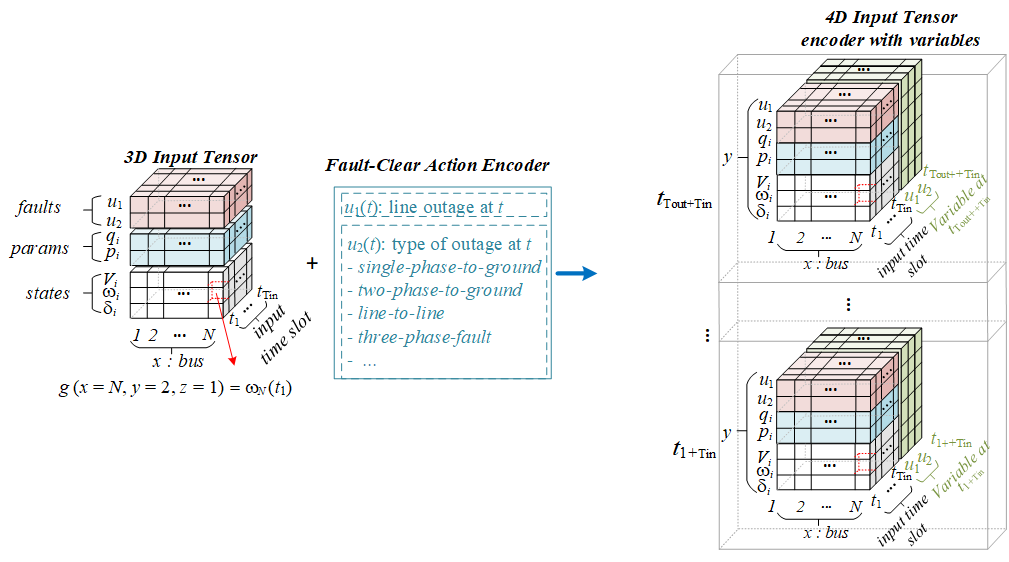

In [ ]:
# duplicate the input tensor on the dimension of output sequence
train_a = train_a.reshape(ntrain,dim_delta,dim_omega,1,int(T_in/sub_T)).repeat([1,1,1,int(T/sub_T),1])
train_u_line = train_u_line.reshape(ntrain,1,dim_omega,int(T/sub_T),1).repeat([1,dim_delta,1,1,1])
train_u_lineidx = train_u_lineidx.reshape(ntrain,1,dim_omega,int(T/sub_T),1).repeat([1,dim_delta,1,1,1])
# attach the future line fault and fault type information to be two addtional input
train_a = torch.cat((train_u_lineidx, train_u_line, train_a), dim=-1)


test_a = test_a.reshape(ntest,dim_delta,dim_omega,1,int(T_in/sub_T)).repeat([1,1,1,int(T/sub_T),1])
test_u_line = test_u_line.reshape(ntest,1,dim_omega,int(T/sub_T),1).repeat([1,dim_delta,1,1,1])
test_u_lineidx = test_u_lineidx.reshape(ntest,1,dim_omega,int(T/sub_T),1).repeat([1,dim_delta,1,1,1])
# attach the future line fault and fault type information to be two addtional input
test_a = torch.cat((test_u_lineidx, test_u_line, test_a), dim=-1)

print(np.shape(train_a))
print(np.shape(test_a))


torch.Size([800, 7, 48, 150, 22])
torch.Size([100, 7, 48, 150, 22])


In [ ]:
# batch normalization
a_normalizer = UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)
y_normalizer = UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

## pad locations (x,y,t)

In [ ]:

gridt = torch.tensor(delta_t*sub_T*np.arange(1,int(T/sub_T)+1), dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, int(T/sub_T), 1).repeat([1, dim_delta,dim_omega, 1, 1])

# attach the time stamp for the output sequence
train_a = torch.cat((gridt.repeat([ntrain,1,1,1,1]), train_a), dim=-1)
test_a = torch.cat((gridt.repeat([ntest,1,1,1,1]), test_a), dim=-1)

print(gridt.size())
print(train_a.size())
print(test_a.size())

torch.Size([1, 7, 48, 150, 1])
torch.Size([800, 7, 48, 150, 23])
torch.Size([100, 7, 48, 150, 23])


In [ ]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)
device = torch.device('cuda')

In [ ]:
print(train_a.size())
print(test_a.size())
print(train_u.size())
print(test_u.size())

torch.Size([800, 7, 48, 150, 23])
torch.Size([100, 7, 48, 150, 23])
torch.Size([800, 3, 48, 150])
torch.Size([100, 3, 48, 150])


# training and evaluation

In [ ]:
epochs = 4000
learning_rate = 0.02
scheduler_step = 100
scheduler_gamma = 0.85

modes1=3
modes2=3
modes3=6
width = 23
model = FNO3d(modes1, modes2, modes3, width,train_a.size()[-1],train_a.size()).cuda()

print(count_params(model))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

record_mse=[]
record_train_l2=[]
record_test_l2=[]
myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(epochs):
    print('current memory allocated: {}'.format(torch.cuda.memory_allocated() / 1024 ** 2))
    print('max memory allocated: {}'.format(torch.cuda.max_memory_allocated() / 1024 ** 2))
    print('cached memory: {}'.format(torch.cuda.memory_cached() / 1024 ** 2))
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    x, y = next(iter( train_loader))
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    out = model(x)[0:batch_size_train, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]

    mse = F.mse_loss(out, y, reduction='mean')
    y = y_normalizer.decode(y)
    out = y_normalizer.decode(out)
    l2 = myloss(out.view(batch_size_train, -1), y.view(batch_size_train, -1))
    l2.backward()

    optimizer.step()
    train_mse += mse.item()
    train_l2 += l2.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)[0:batch_size, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]
            out = y_normalizer.decode(out)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print('episode',ep, '   train_mse', train_mse, '   train_l2', train_l2, '   test_l2', test_l2)

    record_mse.append(train_mse)
    record_train_l2.append(train_l2)
    record_test_l2.append(test_l2)


27122465
current memory allocated: 105.67626953125
max memory allocated: 105.67626953125
cached memory: 106.0


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


Streaming output truncated to the last 5000 lines.
current memory allocated: 904.7275390625
max memory allocated: 9583.4169921875
cached memory: 11486.0
episode 2750    train_mse 0.05361945927143097    train_l2 0.002830679416656494    test_l2 0.04221712589263916
current memory allocated: 904.7275390625
max memory allocated: 9583.4169921875
cached memory: 11486.0
episode 2751    train_mse 0.057923030108213425    train_l2 0.0025939980149269105    test_l2 0.0423125696182251
current memory allocated: 904.7275390625
max memory allocated: 9583.4169921875
cached memory: 11486.0
episode 2752    train_mse 0.04705047979950905    train_l2 0.002281341850757599    test_l2 0.042392244338989256
current memory allocated: 904.7275390625
max memory allocated: 9583.4169921875
cached memory: 11486.0
episode 2753    train_mse 0.05597197636961937    train_l2 0.0026089847087860107    test_l2 0.0424183464050293
current memory allocated: 904.7275390625
max memory allocated: 9583.4169921875
cached memory: 11486

In [ ]:
torch.save(model.state_dict(), 'NPCC_V7O3T3(63+60+450).pt')

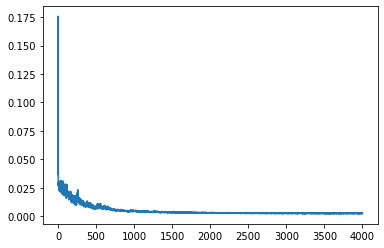

In [ ]:
plt.plot(record_train_l2)

# Statistics

In [ ]:
test_l2 = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()
        print(x.size())

        out = model(x)[0:batch_size, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]
        out = y_normalizer.decode(out)
        batch_mse = torch.sum(torch.square(out-y),dim=(1,2,3))
        y_square = torch.sum(torch.square(y),dim=(1,2,3))
        relative_mse = batch_mse/y_square

        batch_abs = torch.sum(torch.abs(out-y),dim=(1,2,3))
        y_abs = torch.sum(torch.abs(y),dim=(1,2,3))
        relative_abs = batch_abs/y_abs       
        # test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
print('average mse error', torch.mean(relative_mse))
print('average abs error', torch.mean(relative_abs))


torch.Size([100, 7, 48, 150, 23])
average mse error tensor(0.0057, device='cuda:0')
average abs error tensor(0.0262, device='cuda:0')


Text(0, 0.5, 'cdf')

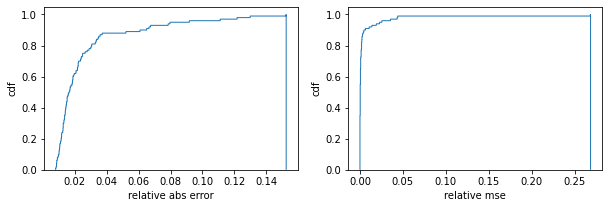

In [ ]:
# plt.hist(relative_mse.cpu().detach().numpy())
fig, ax = plt.subplots(1, 2, figsize=(10, 3)) 
# plt.subplots()
n, bins, patches = ax[0].hist(relative_abs.cpu().detach().numpy(), density=True,  bins=1000,  histtype='step',\
                           cumulative=True, label='Empirical')
ax[0].set_xlabel('relative abs error')
ax[0].set_ylabel('cdf')

n, bins, patches = ax[1].hist(relative_mse.cpu().detach().numpy(), density=True,  bins=1000,  histtype='step',\
                           cumulative=True, label='Empirical')
ax[1].set_xlabel('relative mse')
ax[1].set_ylabel('cdf')

In [ ]:
# plt.boxplot(relative_mse.cpu().detach().numpy())
quantile_precent = [0.7,0.8,0.9,0.95, 0.99]
quantile_mse = np.quantile(relative_mse.cpu().detach().numpy(), quantile_precent)
print('relative mse for quantile', quantile_precent, '\n', 'is', quantile_mse)

relative mse for quantile [0.7, 0.8, 0.9, 0.95, 0.99] 
 is [0.00101582 0.00215821 0.00501962 0.02316879 0.04644883]


## plot performance

In [ ]:
sort_idx=np.argsort(relative_mse.cpu().detach().numpy())

<Figure size 1800x800 with 0 Axes>

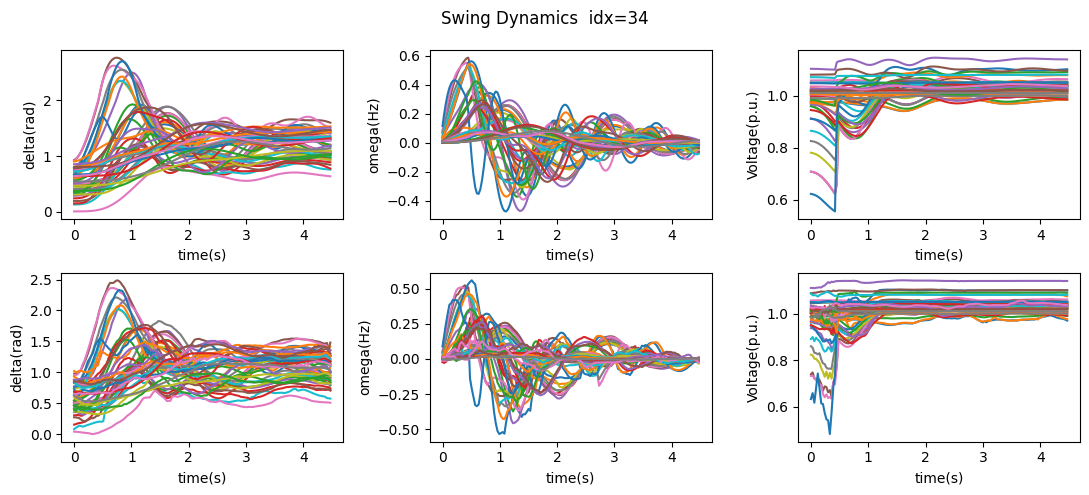

<Figure size 432x288 with 0 Axes>

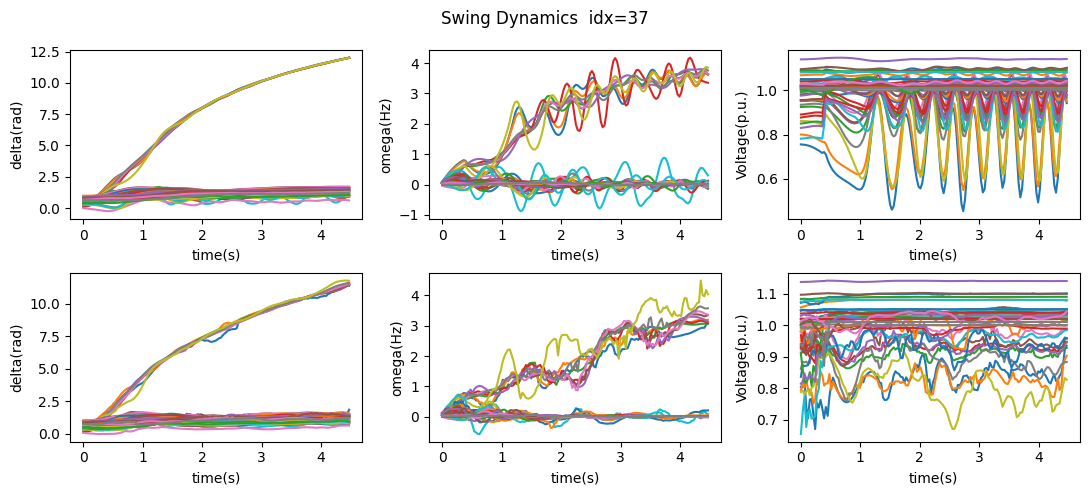

<Figure size 432x288 with 0 Axes>

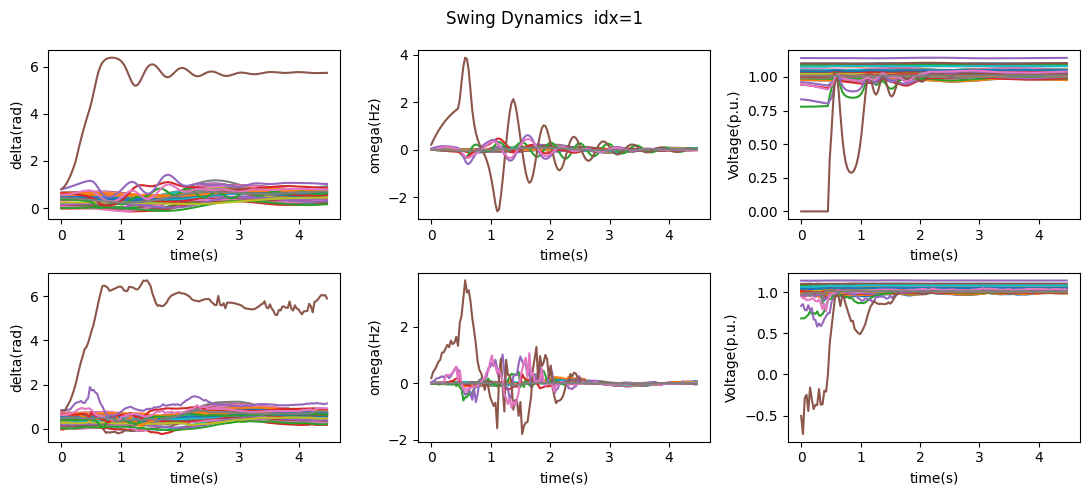

<Figure size 432x288 with 0 Axes>

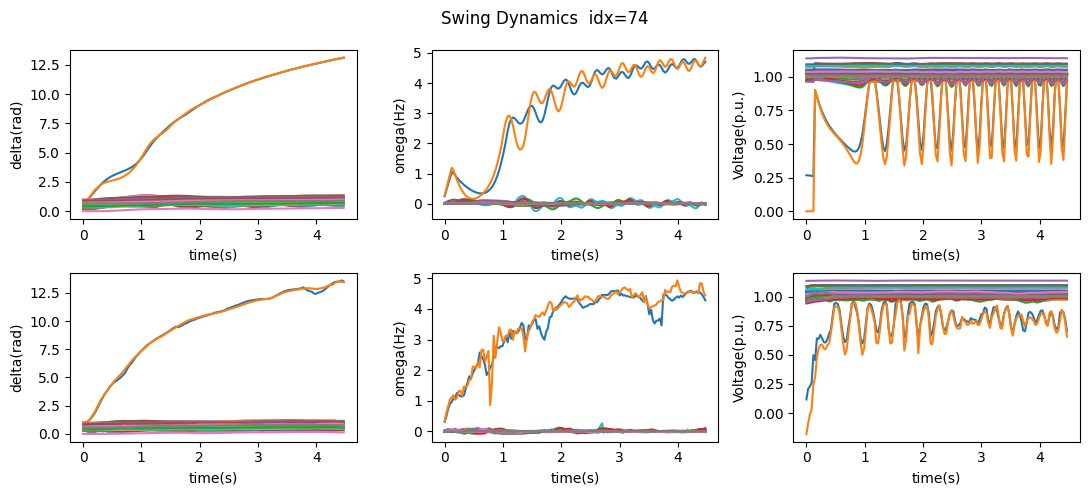

<Figure size 432x288 with 0 Axes>

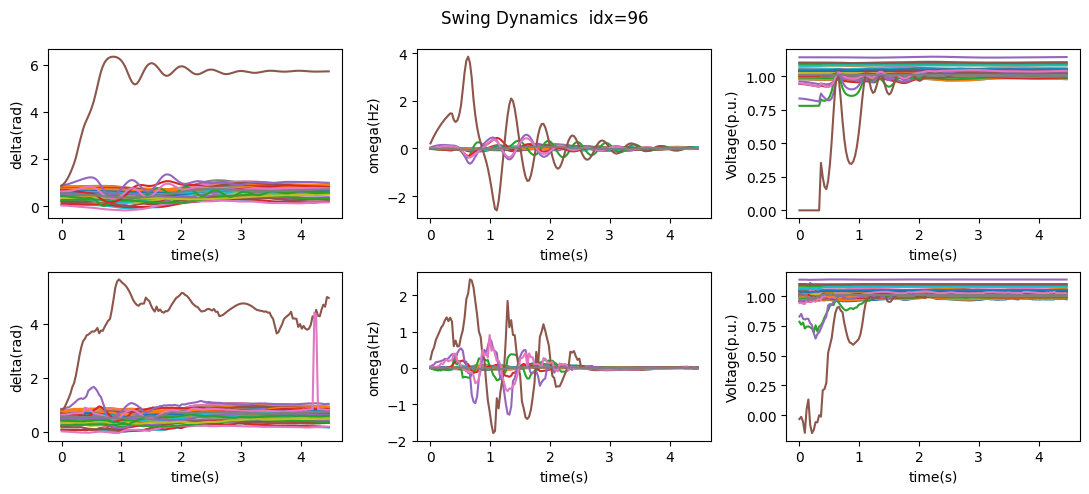

<Figure size 432x288 with 0 Axes>

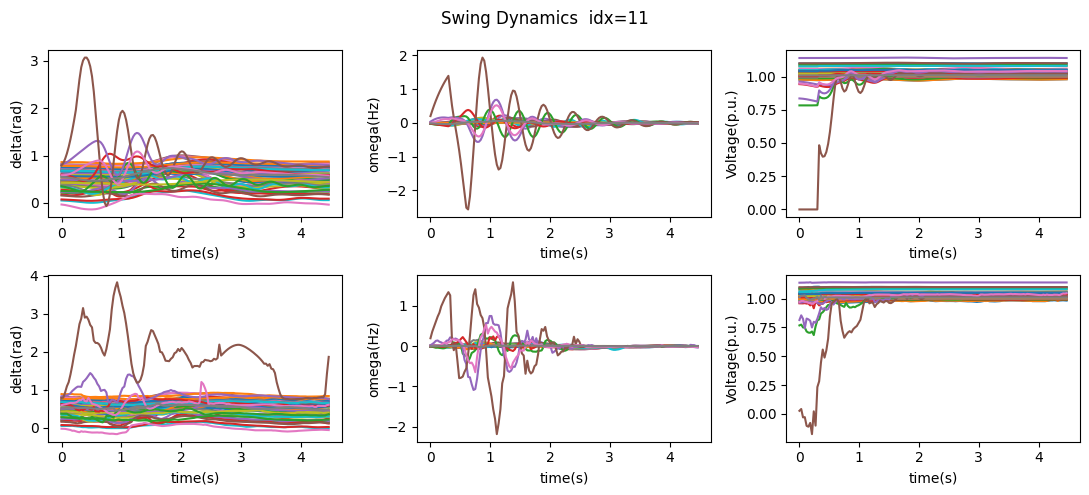

<Figure size 432x288 with 0 Axes>

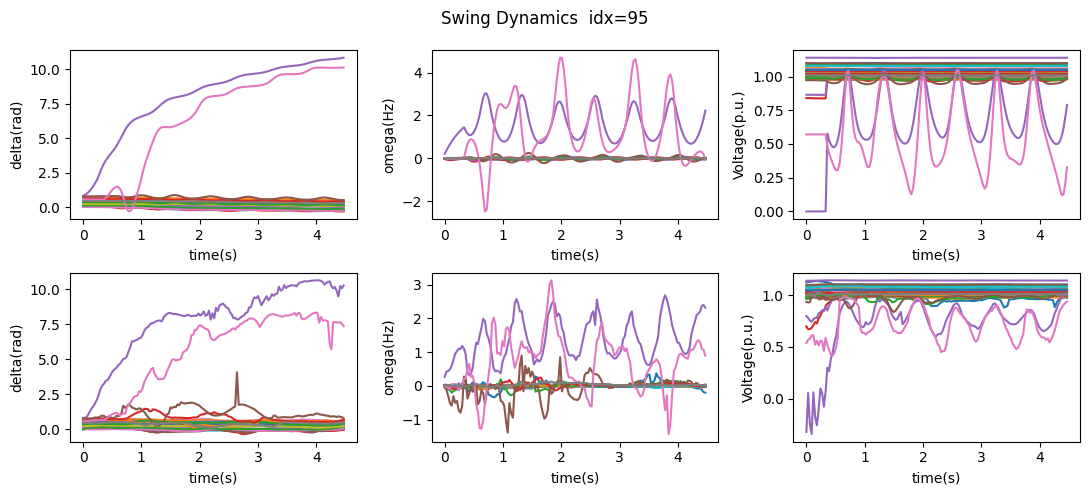

<Figure size 432x288 with 0 Axes>

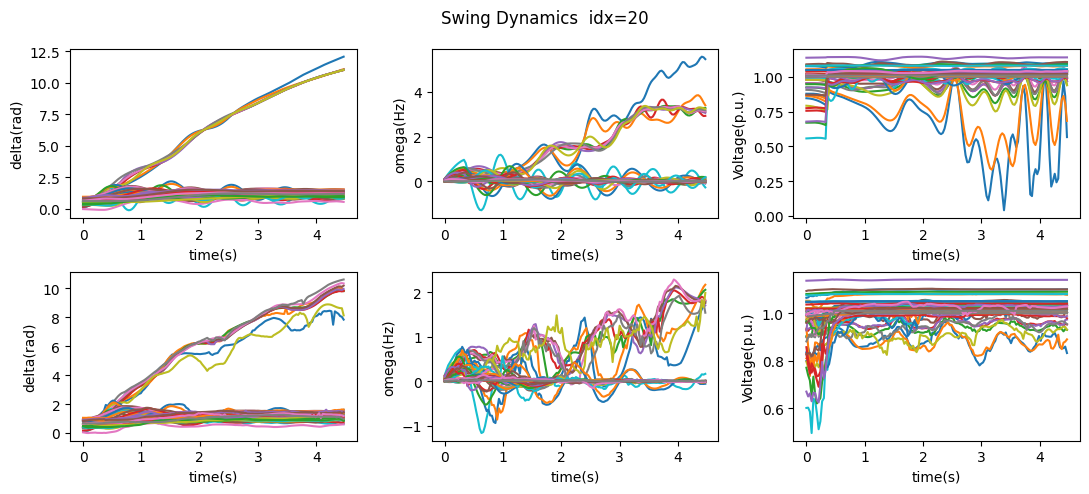

<Figure size 432x288 with 0 Axes>

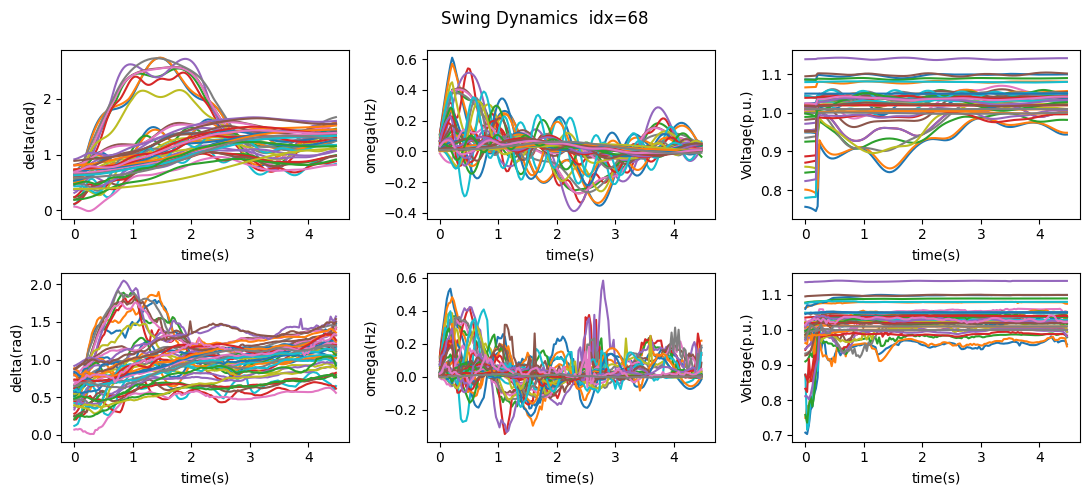

<Figure size 432x288 with 0 Axes>

In [ ]:
# check the worsest case
plt.ion()
fig = plt.figure(figsize=(18,8), dpi=100)
list_idx = sort_idx[-10:-1]
for test_idx in list_idx:
    y = test_u[test_idx:test_idx+1]
    x = test_a[test_idx:test_idx+1]
    x = x.cuda()
    fig=plt.figure(figsize=(11,5), dpi=100)
    fig.suptitle('Swing Dynamics  idx='+str(test_idx))

    TimeRecord=np.arange(0,y.size()[-1])*delta_t*sub_T
    plt.subplot(2,3,1)
    plt.plot(TimeRecord,torch.transpose(y[0,0,:,:],0,1))
    plt.xlabel('time(s)')
    plt.ylabel('delta(rad)')
    plt.subplot(2,3,2)
    plt.plot(TimeRecord,torch.transpose(y[0,1,:,:],0,1))
    plt.xlabel('time(s)')
    plt.ylabel('omega(Hz)')
    plt.subplot(2,3,3)
    plt.plot(TimeRecord,torch.transpose(y[0,2,:,:],0,1))
    plt.xlabel('time(s)')
    plt.ylabel('Voltage(p.u.)')
    plt.subplot(2,3,4)
    out = model(x)[0:1, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]
    out = y_normalizer.decode(out)
    plt.plot(TimeRecord,torch.transpose(out[0,0,:,:],0,1).cpu().detach().numpy())
    plt.xlabel('time(s)')
    plt.ylabel('delta(rad)')
    plt.subplot(2,3,5)
    plt.plot(TimeRecord,torch.transpose(out[0,1,:,:],0,1).cpu().detach().numpy())
    plt.xlabel('time(s)')
    plt.ylabel('omega(Hz)')
    plt.subplot(2,3,6)
    plt.plot(TimeRecord,torch.transpose(out[0,2,:,:],0,1).cpu().detach().numpy())
    plt.xlabel('time(s)')
    plt.ylabel('Voltage(p.u.)')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    plt.pause(0.01)
    plt.clf()



<Figure size 1800x800 with 0 Axes>

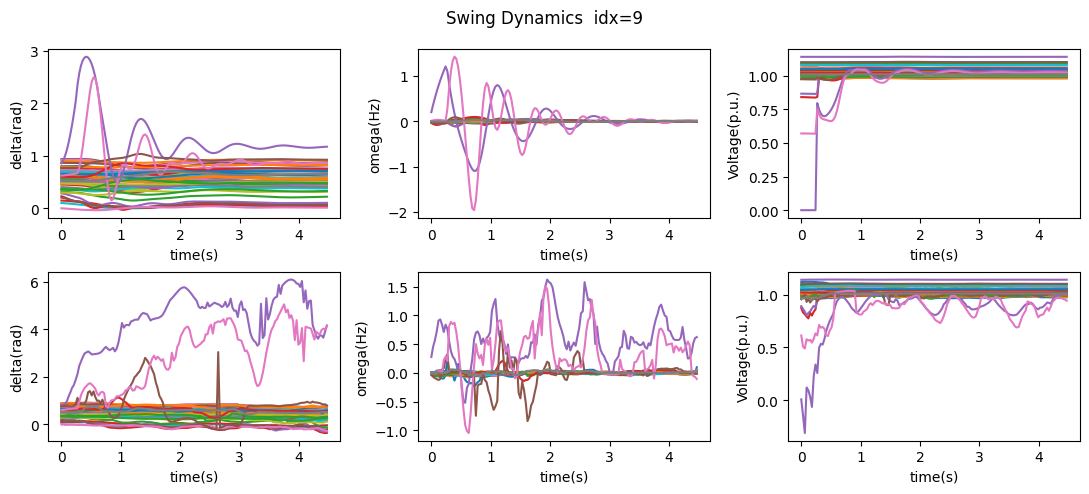

<Figure size 432x288 with 0 Axes>

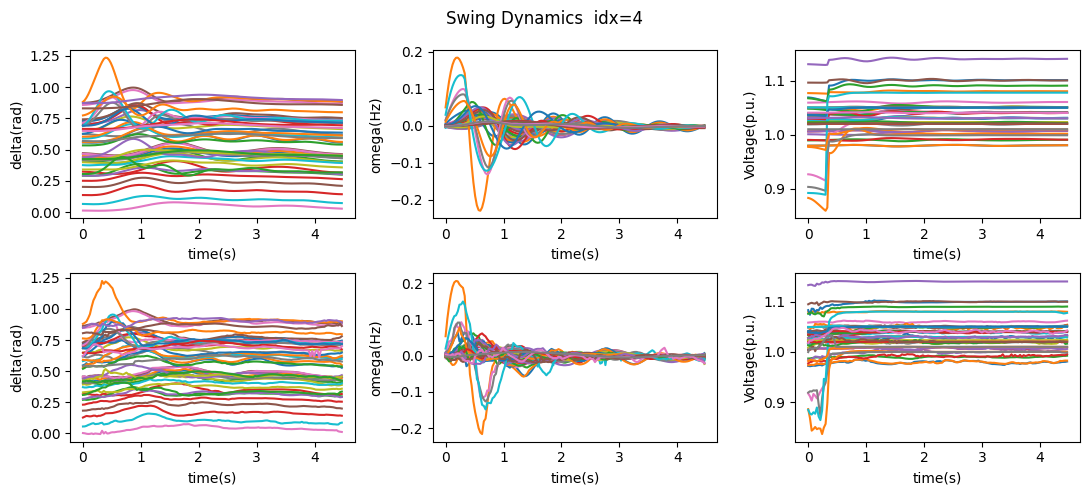

<Figure size 432x288 with 0 Axes>

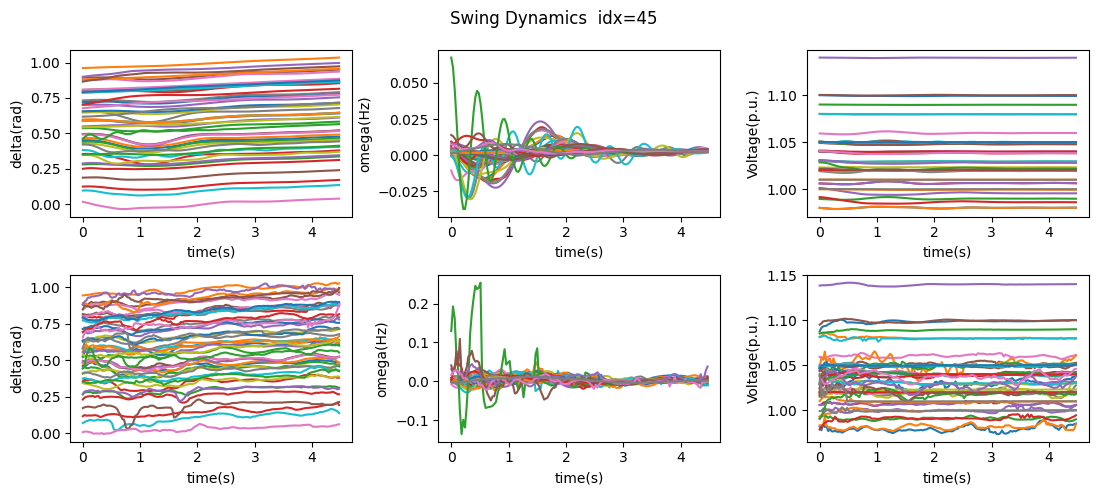

<Figure size 432x288 with 0 Axes>

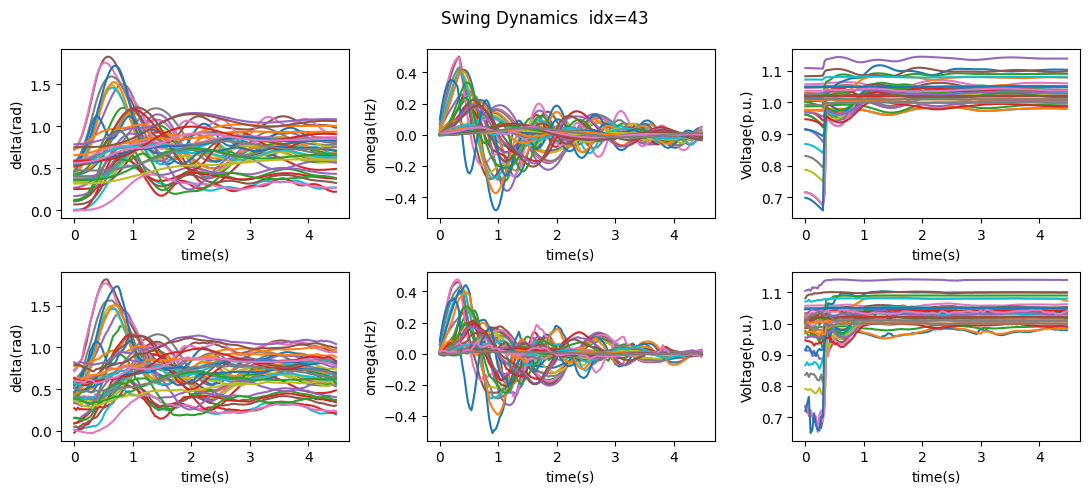

<Figure size 432x288 with 0 Axes>

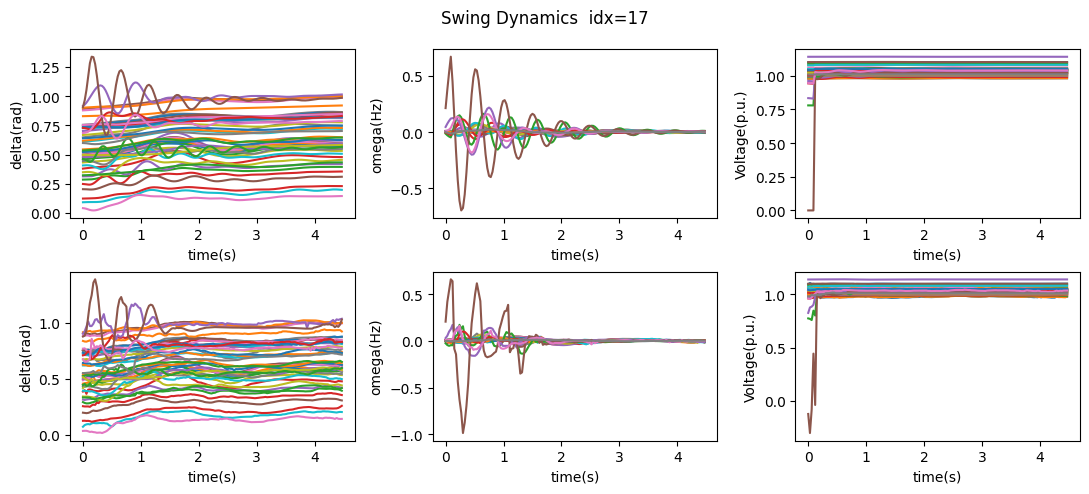

<Figure size 432x288 with 0 Axes>

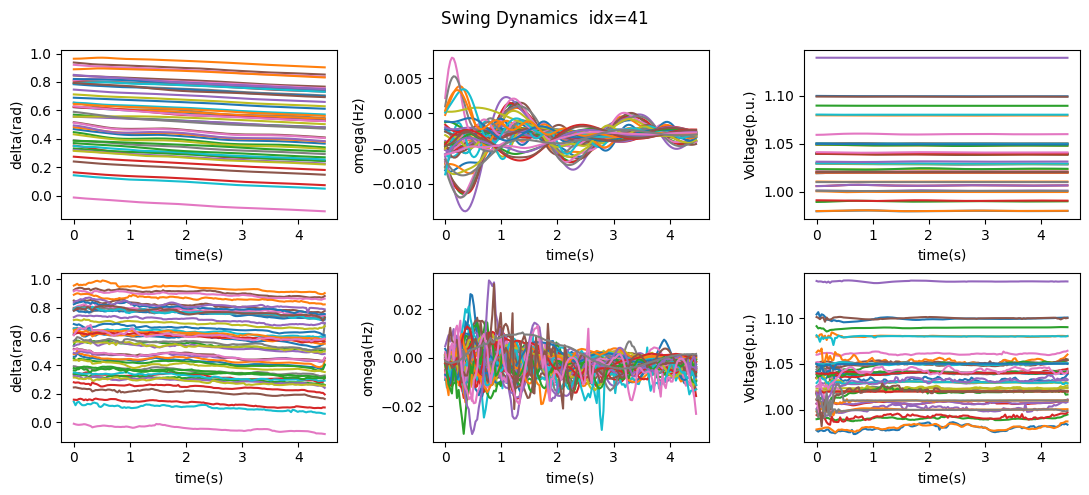

<Figure size 432x288 with 0 Axes>

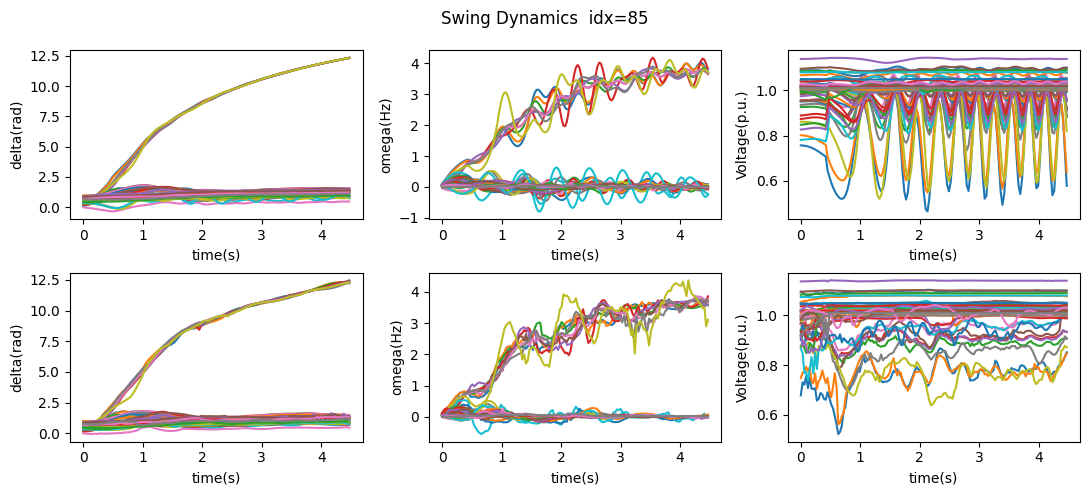

<Figure size 432x288 with 0 Axes>

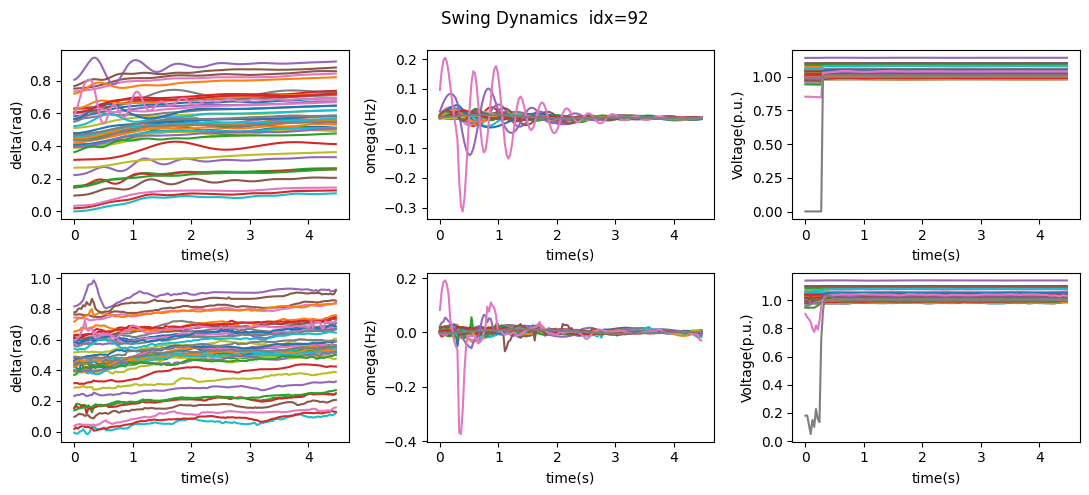

<Figure size 432x288 with 0 Axes>

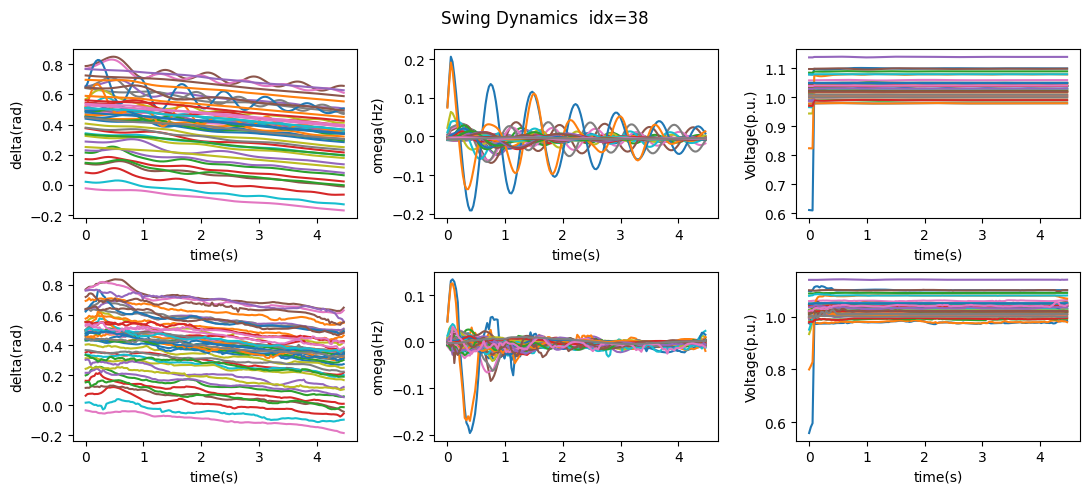

<Figure size 432x288 with 0 Axes>

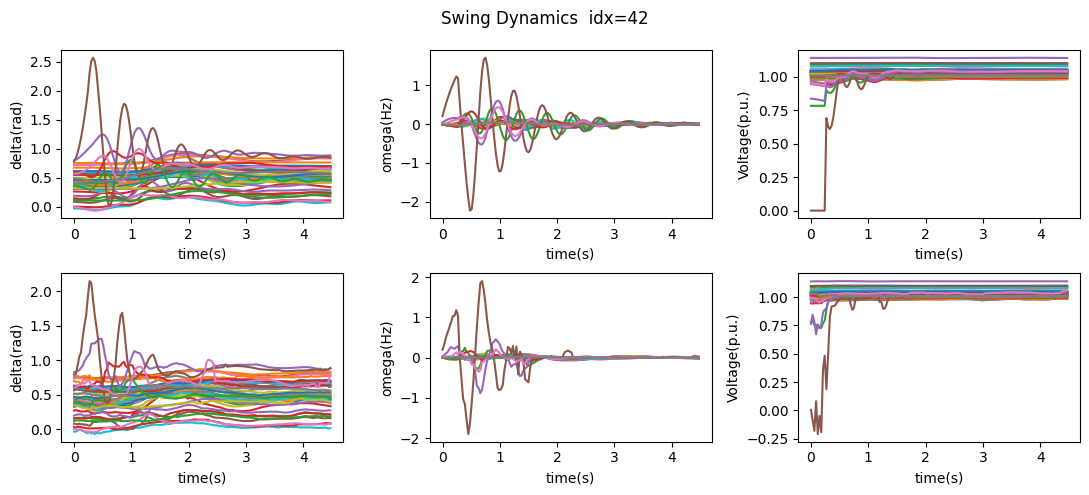

<Figure size 432x288 with 0 Axes>

In [ ]:
# randomly print 10 cases
plt.ion()
fig = plt.figure(figsize=(18,8), dpi=100)

for i in range(10):
    test_idx=random.randint(3, test_u.size()[0]-1)
    y = test_u[test_idx:test_idx+1]
    x = test_a[test_idx:test_idx+1]
    x = x.cuda()
    fig=plt.figure(figsize=(11,5), dpi=100)
    fig.suptitle('Swing Dynamics  idx='+str(test_idx))

    TimeRecord=np.arange(0,y.size()[-1])*delta_t*sub_T
    plt.subplot(2,3,1)
    plt.plot(TimeRecord,torch.transpose(y[0,0,:,:],0,1))
    plt.xlabel('time(s)')
    plt.ylabel('delta(rad)')
    plt.subplot(2,3,2)
    plt.plot(TimeRecord,torch.transpose(y[0,1,:,:],0,1))
    plt.xlabel('time(s)')
    plt.ylabel('omega(Hz)')
    plt.subplot(2,3,3)
    plt.plot(TimeRecord,torch.transpose(y[0,2,:,:],0,1))
    plt.xlabel('time(s)')
    plt.ylabel('Voltage(p.u.)')
    plt.subplot(2,3,4)
    out = model(x)[0:1, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]
    out = y_normalizer.decode(out)
    plt.plot(TimeRecord,torch.transpose(out[0,0,:,:],0,1).cpu().detach().numpy())
    plt.xlabel('time(s)')
    plt.ylabel('delta(rad)')
    plt.subplot(2,3,5)
    plt.plot(TimeRecord,torch.transpose(out[0,1,:,:],0,1).cpu().detach().numpy())
    plt.xlabel('time(s)')
    plt.ylabel('omega(Hz)')
    plt.subplot(2,3,6)
    plt.plot(TimeRecord,torch.transpose(out[0,2,:,:],0,1).cpu().detach().numpy())
    plt.xlabel('time(s)')
    plt.ylabel('Voltage(p.u.)')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    plt.pause(0.01)
    plt.clf()




# Type1 and Type2 error

In [ ]:
# type 1: unstable predicted to be stable
# type 2: stable predicted to be unstable

Batch_delta_omaga_Time_max_last = np.amax(abs(Batch_delta_omaga_Time[-ntest:,1,:,T0+T_in+T]),  axis=(-1))
threshold_higher = 0.5
mean_idx = -20 # If the mean frequency deciation in the last 20 steps is larger than 0.2, than the case is unstable
idx_select_unstable = np.where((Batch_delta_omaga_Time_max_last>threshold_higher))
idx_select_unstable[0]
x = test_a[idx_select_unstable[0]]
x = x.cuda()
out = model(x)[:, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]
out = y_normalizer.decode(out)
out = out.cpu().detach().numpy()
predict_unstable = np.amax(np.mean(abs(out[:,1,:,mean_idx:-1]),axis=(-1)),  axis=(-1))>threshold_higher
print('predict unstable wrong', 1-sum(predict_unstable)/np.shape(idx_select_unstable[0]))

Batch_delta_omaga_Time_max_last = np.amax(abs(Batch_delta_omaga_Time[-ntest:,1,:,T0+T_in+T]),  axis=(-1))
threshold_higher = 0.5
idx_select_stable = np.where((Batch_delta_omaga_Time_max_last<=threshold_higher))
x = test_a[idx_select_stable[0]]
x = x.cuda()
out = model(x)[:, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]
out = y_normalizer.decode(out)
out = out.cpu().detach().numpy()
predict_stable = np.amax(np.mean(abs(out[:,1,:,mean_idx:-1]),axis=(-1)),  axis=(-1))<threshold_higher

print('predict stable wrong', 1-sum(predict_stable)/np.shape(idx_select_stable[0]))

predict unstable wrong [0.]
predict stable wrong [0.01075269]


# computational time

In [ ]:
num_time_calc=0
for test_idx in range(0, test_u.size()[0]):

    y=test_u[test_idx:test_idx+1]
    x=test_a[test_idx:test_idx+1]
    x=x.cuda()

    t1=default_timer()
    out = model(x)[0:1, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]
    out = y_normalizer.decode(out)
    t2=default_timer()
    num_time_calc+=t2-t1

print('time', num_time_calc/test_u.size()[0])

time 0.0037448223899900768
